# Face Generation


In [2]:
data_dir = '/input'


import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
 the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

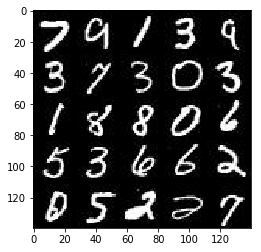

In [9]:
show_n_images = 25


%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  

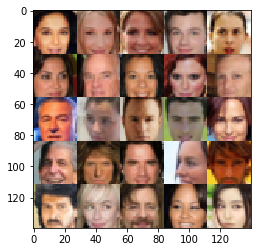

In [10]:
show_n_images = 25


mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data


### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input


In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return (input_real, input_z, learning_rate)


tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator


In [18]:
# Constants
alpha = 0.2
dropout = 0.3
smooth = 0.1

def leaky_relu(x):
    return tf.maximum(alpha * x, x)
    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
  
    def conv2d_k5_s2(x, dim):
        """2-dimensional convolution with random normal kernal of 5 and stride of 2 with same padding"""
        return tf.layers.conv2d(x,
                                dim,
                                5,
                                strides=2,
                                padding='same',
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xchannels with NO batch normalization
        x1 = conv2d_k5_s2(images, 64)
        relu1 = leaky_relu(x1)
        # 14x14x64
        
        x2 = conv2d_k5_s2(relu1, 128)
        x2_d = tf.layers.dropout(x2, rate=dropout, training=True)
        bn2 = tf.layers.batch_normalization(x2_d, training=True)
        relu2 = leaky_relu(bn2)
        # 7x7x128
        
        x3 = conv2d_k5_s2(relu2, 256)
        x3_d = tf.layers.dropout(x3, rate=dropout, training=True)
        bn3 = tf.layers.batch_normalization(x3_d, training=True)
        relu3 = leaky_relu(bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
#         print ("discriminator - images shape: {}".format (images.shape))
#         print ("discriminator - x1 shape: {}".format (x1.shape))
#         print ("discriminator - x2 shape: {}".format (x2.shape))
#         print ("discriminator - x3 shape: {}".format (x3.shape))
#         print ("discriminator - logits shape: {}".format (logits.shape))
        
        return (output, logits)


tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse=not is_train
    
    def conv2d_trans(x, dim):
        """2-dimensional de-convolution with random normal kernal of 5 and stride of 2 with same padding"""
        return tf.layers.conv2d_transpose(x,
                                          dim,
                                          5,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1_d = tf.layers.dropout(x1, rate=dropout, training=True)
        x1 = tf.layers.batch_normalization(x1_d, training=is_train)
        x1 = leaky_relu(x1)
        # 7x7x512 now
        
        x2 = conv2d_trans(x1, 256)
        x2_d = tf.layers.dropout(x2, rate=dropout, training=True)
        x2 = tf.layers.batch_normalization(x2_d, training=is_train)
        x2 = leaky_relu(x2)
        # 14x14x256 now
        
        logits = conv2d_trans(x2, out_channel_dim)
        
        output = tf.tanh(logits)*0.5
#         print ("generator - z shape: {}".format (z.shape))
#         print ("generator - x1 shape: {}".format (x1.shape))
#         print ("generator - x2 shape: {}".format (x2.shape))
#         print ("generator - logits shape: {}".format (logits.shape))
        
        return output


tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions :
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake 
    
    return (d_loss, g_loss)



tests.test_model_loss(model_loss)

Tests Passed


### Optimization


In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. 

In [22]:

import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`



In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #  Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1) 
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,
                                                     input_real: batch_images,
                                                     lr: learning_rate})

                if steps % 375 == 0:      
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
            # Generate at end of epoch 
            show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1162... Generator Loss: 1.1178
Epoch 1/2... Discriminator Loss: 0.7872... Generator Loss: 2.4435
Epoch 1/2... Discriminator Loss: 0.8849... Generator Loss: 2.7705
Epoch 1/2... Discriminator Loss: 0.9076... Generator Loss: 1.3667
Epoch 1/2... Discriminator Loss: 0.9189... Generator Loss: 1.1298


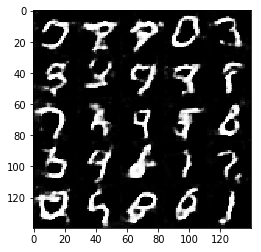

Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 1.2114
Epoch 2/2... Discriminator Loss: 0.9119... Generator Loss: 2.3988
Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 2.1056
Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.6462
Epoch 2/2... Discriminator Loss: 0.7425... Generator Loss: 1.7712


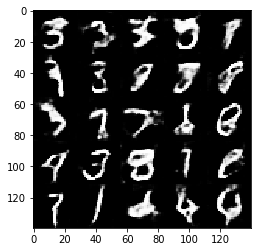

In [27]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4

tf.reset_default_graph()


epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  

Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 3.3023
Epoch 1/1... Discriminator Loss: 0.6596... Generator Loss: 2.3222
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 3.6261
Epoch 1/1... Discriminator Loss: 0.5294... Generator Loss: 1.8653
Epoch 1/1... Discriminator Loss: 0.7959... Generator Loss: 1.3455
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 2.6079
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 1.4081
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 2.5557
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.2331
Epoch 1/1... Discriminator Loss: 0.6063... Generator Loss: 2.6535
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 1.5099
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 1.8627
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 0.9354
Epoch 1/1.

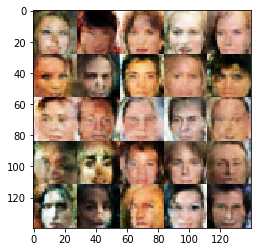

In [30]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

tf.reset_default_graph()


epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)